# Overview of Assignment 2

This assignment explores fundamental concepts and techniques for image retrieval. The main objective is to develop an image retrieval system that efficiently searches a database to find visually similar images to a query image. This will involve implementing and comparing different feature extraction methods, similarity measures, and indexing structures covered in lectures.

#   Enter your details below

# Name

Hao Phuoc Tang

# Banner ID

B00909068

# Q1: Setting up the libraries and environment

In [49]:
## Import the usual libraries
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np
from scipy.spatial.distance import cdist
from collections import defaultdict, Counter
from pinecone import Pinecone


### Preprocessing the images & print out sample

In [11]:
def load_and_preprocess_cnn(image_path):
    weights = models.VGG16_Weights.DEFAULT
    preprocess_cnn = weights.transforms()
    img = Image.open(image_path).convert('RGB')
    img_tensor = preprocess_cnn(img)
    return img_tensor

In [12]:
def load_and_preprocess_sift(image_path):
    img = Image.open(image_path).convert('RGB')
    img_np = np.array(img)
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    return gray

# Q2: Feature Extraction

## 1 a) + b)

### SIFT eature extraction using OpenCV

In [ ]:
data_dir = 'cats_and_dogs'

In [16]:
data_dir = 'cats_and_dogs'

## SIFT eature extraction using OpenCV
sift = cv2.SIFT_create()


samples_image_path = ['train/cats/0.jpg',
                      'train/cats/1.jpg',
                      'train/dogs/0.jpg',
                      'train/dogs/1.jpg']
samples_image_path = [os.path.join(data_dir, path) for path in samples_image_path]

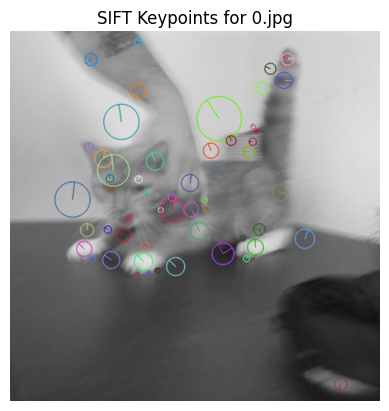

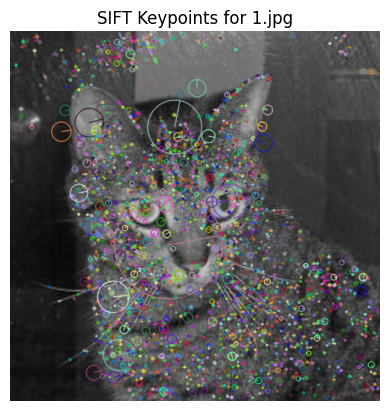

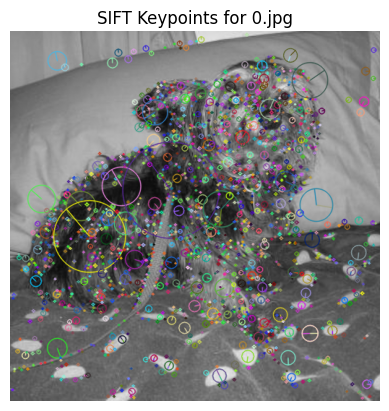

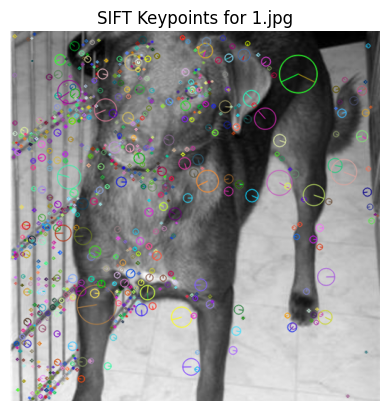

In [17]:
for image_path in samples_image_path:
    gray = load_and_preprocess_sift(image_path)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    img = cv2.drawKeypoints(gray, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img, cmap='gray')
    plt.title(f'SIFT Keypoints for {os.path.basename(image_path)}')
    plt.axis('off')
    plt.show()


### Explanation
-To achieve scale invariance, SIFT extracts keypoints using Difference of Gaussian (DoG) approach, the DoG difference then go through convolutional layers to produce the final keypoints and descriptors.
-To achieve rotation invariance, SIFT assigns a dominant orientation to each keypoint based on the local image gradient directions.

## 2 a) 

In [18]:
## I will use the VGG16 model to extract features from the images
# Load pre-trained VGG16 model
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT).eval()

# Function to extract features from last conv layer and final FC layer
def extract_vgg16_features(img_tensor):
    with torch.no_grad():
        # Features from last conv layer
        conv_features = vgg16.features(img_tensor.unsqueeze(0))  # shape: [1, 512, 7, 7]
        # Flatten for classifier
        flattened = torch.flatten(conv_features, 1)
        # Features from final FC layer
        fc_features = vgg16.classifier(flattened)  # shape: [1, 1000]
    return conv_features.squeeze().numpy(), fc_features.squeeze().numpy()

# Extract and print features for each sample image
for image_path in samples_image_path:
    img_tensor = load_and_preprocess_cnn(image_path)
    conv_feat, fc_feat = extract_vgg16_features(img_tensor)
    print(f"Image: {image_path}")
    print(f"Last conv layer feature shape: {conv_feat.shape}")  # (512, 7, 7)
    print(f"Final FC layer feature shape: {fc_feat.shape}")     # (1000,)
    print('-'*40)

Image: cats_and_dogs/train/cats/0.jpg
Last conv layer feature shape: (512, 7, 7)
Final FC layer feature shape: (1000,)
----------------------------------------
Image: cats_and_dogs/train/cats/1.jpg
Last conv layer feature shape: (512, 7, 7)
Final FC layer feature shape: (1000,)
----------------------------------------
Image: cats_and_dogs/train/dogs/0.jpg
Last conv layer feature shape: (512, 7, 7)
Final FC layer feature shape: (1000,)
----------------------------------------
Image: cats_and_dogs/train/dogs/1.jpg
Last conv layer feature shape: (512, 7, 7)
Final FC layer feature shape: (1000,)
----------------------------------------


## 2b
- The last convolutional layer outputs 3D feature maps, with 512 channels and spatial dimensions of 7x7. These features retain spatial information about where patterns (edges, textures, shapes) appear in the image. The activations here capture mid- and high-level visual patterns, such as object parts and arrangements, and are less abstracted than the final classification output.
- The final fully connected layer outputs a 1D vector of 1000 values, representing the probabilities of the image belonging to each of the 1000 classes in the ImageNet dataset. This vector is highly abstracted, as it summarizes the entire image into a single probability distribution over classes, losing detailed spatial information.
- The more suitable layer for image retrieval is the last convolutional layer, as it retains rich spatial information and mid-level features that are useful for comparing visual similarity between images. The final fully connected layer's output is too abstracted and class-specific for general image retrieval tasks.

# Q3 Similarity Measures


## 3 a)

In [24]:
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    if norm1 == 0 or norm2 == 0:
        return 0.0  # Avoid division by zero
    return dot_product / (norm1 * norm2)

def euclidean_distance(vec1, vec2):
    diff = vec1 - vec2
    return np.sqrt(np.sum(diff ** 2))

## 3 b)

In [92]:
cats_train_folder = 'cats_and_dogs/train/cats'
dogs_train_folder = 'cats_and_dogs/train/dogs'

# Get sorted file lists for reproducibility
cat_imgs = sorted([os.path.join(cats_train_folder, f) for f in os.listdir(cats_train_folder) if os.path.isfile(os.path.join(cats_train_folder, f))])[:150]
dog_imgs = sorted([os.path.join(dogs_train_folder, f) for f in os.listdir(dogs_train_folder) if os.path.isfile(os.path.join(dogs_train_folder, f))])[:150]

image_paths = cat_imgs + dog_imgs

In [93]:
## I will use SIFT features to compute similarity

# SIFT feature extraction
sift = cv2.SIFT_create()
train_descriptors = []
train_image_paths = []

for img_path in image_paths:
    gray = load_and_preprocess_sift(img_path)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is not None:
        train_descriptors.append(descriptors.mean(axis=0))
        train_image_paths.append(img_path)
        


In [94]:
# Get the SIFT descriptors for the test image
test_image_path = 'cats_and_dogs/validation/cats/2000.jpg'
gray_test = load_and_preprocess_sift(test_image_path)
keypoints_test, descriptors_test = sift.detectAndCompute(gray_test, None)
test_descriptor = descriptors_test.mean(axis=0)

print(f"Test image: {test_image_path}")
print(f"Test descriptor shape: {test_descriptor.shape}")

Test image: cats_and_dogs/validation/cats/2000.jpg
Test descriptor shape: (128,)


In [95]:
## Compute top K
K = 5  # Top-K

# Cosine similarity
cosine_scores = [cosine_similarity(test_descriptor, train_descriptor) for train_descriptor in train_descriptors]
topk_cosine_idx = np.argsort(cosine_scores)[-K:][::-1]

# Euclidean distance
euclidean_scores = [euclidean_distance(test_descriptor, train_descriptor) for train_descriptor in train_descriptors]
topk_euclidean_idx = np.argsort(euclidean_scores)[:K]

Query Image:


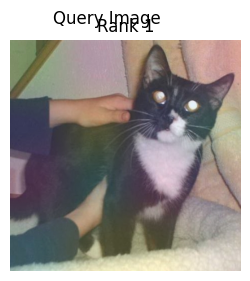

Top-K (Cosine Similarity):


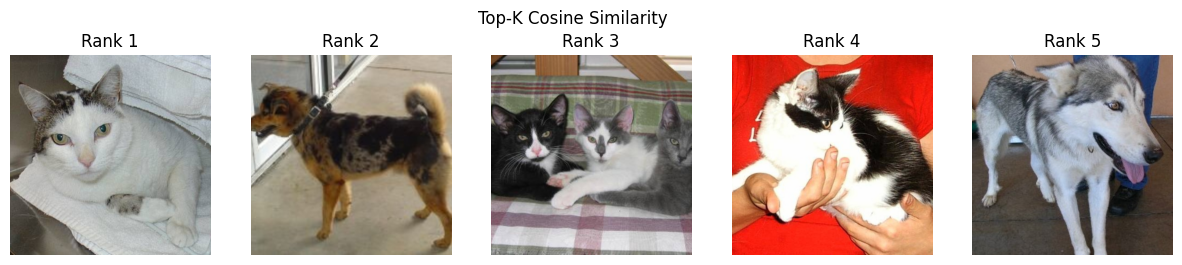

Top-K (Euclidean Distance):


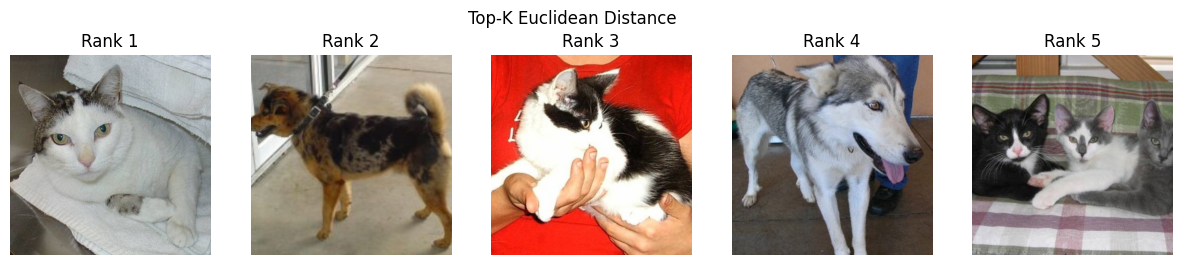

In [96]:
# Display top K for cosine similarity
def show_images(image_paths, title):
    plt.figure(figsize=(15, 3))
    for i, path in enumerate(image_paths):
        img = Image.open(path)
        plt.subplot(1, len(image_paths), i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Rank {i+1}')
    plt.suptitle(title)
    plt.show()

# Display query image
print("Query Image:")
show_images([test_image_path], "Query Image")

# Display top-K cosine similarity results
print("Top-K (Cosine Similarity):")
show_images([train_image_paths[i] for i in topk_cosine_idx], "Top-K Cosine Similarity")

# Display top-K Euclidean distance results
print("Top-K (Euclidean Distance):")
show_images([train_image_paths[i] for i in topk_euclidean_idx], "Top-K Euclidean Distance")

# Q4 Image Retrieval Pipeline


In [27]:
import numpy as np
import cv2
from sklearn.cluster import KMeans

def extract_sift_features(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Create a SIFT feature extractor
    sift = cv2.SIFT_create()
    
    # Detect and compute SIFT features
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    # print("keypoint :",keypoints)
    # print("descriptors :",descriptors)
    
    return descriptors

def cluster_features(features, k):
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    
    # Get the cluster centers (visual words)
    visual_words = kmeans.cluster_centers_
    
    return visual_words

## 4 a)

In [85]:
# Set all the path for the training images
cats_train_folder = 'cats_and_dogs/train/cats'
dogs_train_folder = 'cats_and_dogs/train/dogs'
image_paths = [os.path.join(cats_train_folder, f) for f in os.listdir(cats_train_folder) if os.path.isfile(os.path.join(cats_train_folder, f))]
image_paths += [os.path.join(dogs_train_folder, f) for f in os.listdir(dogs_train_folder) if os.path.isfile(os.path.join(dogs_train_folder, f))]

In [86]:
all_descriptors = []
image_descriptor_list = []

for path in image_paths:
    img = cv2.imread(path)
    descriptors = extract_sift_features(img)
    if descriptors is not None:
        all_descriptors.append(descriptors)
        image_descriptor_list.append(descriptors)
    else:
        image_descriptor_list.append(np.array([]))  

In [87]:
## Create codebook
all_descriptors_stacked = np.vstack([desc for desc in all_descriptors if desc is not None])

k = 50  
visual_words = cluster_features(all_descriptors_stacked, k)

In [88]:
## Represent each image as list of visual words
image_word_ids = []

for descriptors in image_descriptor_list:
    if descriptors.shape[0] == 0:
        image_word_ids.append([])  # No features for this image
        continue
    # Compute distances to all cluster centers (visual words)
    distances = cdist(descriptors, visual_words)
    # Assign each descriptor to the nearest visual word (cluster center)
    word_ids = np.argmin(distances, axis=1)
    image_word_ids.append(word_ids.tolist())

## 4 b)

In [89]:
## Extract SIFT features from the query image
query_img = cv2.imread('cats_and_dogs/validation/cats/2000.jpg')
query_descriptors = extract_sift_features(query_img)

# Assign query to its nearest visual word in the codebook
if query_descriptors is not None and len(query_descriptors) > 0:
   
    distances = cdist(query_descriptors, visual_words)
    # Assign each descriptor to the nearest visual word (cluster center)
    query_word_ids = np.argmin(distances, axis=1)
else:
    query_word_ids = []

print("Visual word IDs for query image:", query_word_ids.shape)

Visual word IDs for query image: (297,)


## 4 c)

In [90]:
inverted_index = defaultdict(set)

for img_idx, word_id_list in enumerate(image_word_ids):
    for word_id in set(word_id_list):  
        inverted_index[word_id].add(image_paths[img_idx])

inverted_index = {word_id: list(paths) for word_id, paths in inverted_index.items()}

# Testing the inverted index
print("Images containing visual word 0:", inverted_index.get(0, []))

Images containing visual word 0: ['cats_and_dogs/train/dogs/128.jpg', 'cats_and_dogs/train/cats/744.jpg', 'cats_and_dogs/train/dogs/759.jpg', 'cats_and_dogs/train/cats/491.jpg', 'cats_and_dogs/train/dogs/854.jpg', 'cats_and_dogs/train/cats/574.jpg', 'cats_and_dogs/train/cats/917.jpg', 'cats_and_dogs/train/cats/58.jpg', 'cats_and_dogs/train/dogs/769.jpg', 'cats_and_dogs/train/dogs/879.jpg', 'cats_and_dogs/train/dogs/280.jpg', 'cats_and_dogs/train/dogs/650.jpg', 'cats_and_dogs/train/cats/139.jpg', 'cats_and_dogs/train/cats/237.jpg', 'cats_and_dogs/train/cats/282.jpg', 'cats_and_dogs/train/cats/86.jpg', 'cats_and_dogs/train/cats/332.jpg', 'cats_and_dogs/train/cats/456.jpg', 'cats_and_dogs/train/dogs/633.jpg', 'cats_and_dogs/train/cats/350.jpg', 'cats_and_dogs/train/cats/431.jpg', 'cats_and_dogs/train/dogs/594.jpg', 'cats_and_dogs/train/dogs/288.jpg', 'cats_and_dogs/train/cats/792.jpg', 'cats_and_dogs/train/cats/90.jpg', 'cats_and_dogs/train/cats/55.jpg', 'cats_and_dogs/train/cats/296.jpg'

## 4 d)

Query Image:


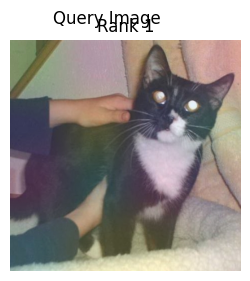

Top-K images sharing most visual words with the query:


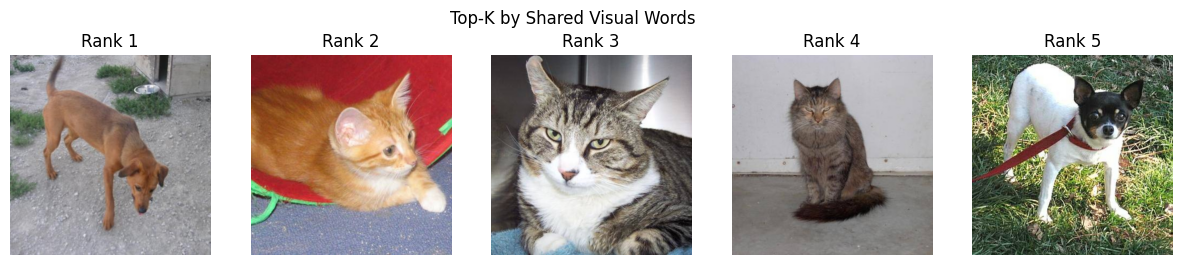

In [91]:
K = 5 # Keep the same K

# Count how many times each database image shares a visual word with the query
image_counter = Counter()
for word_id in set(query_word_ids):
    for img_path in inverted_index.get(word_id, []):
        image_counter[img_path] += 1

topk_images = [img for img, _ in image_counter.most_common(K)]
    
print("Query Image:")
show_images([test_image_path], "Query Image")

print("Top-K images sharing most visual words with the query:")
show_images(topk_images, "Top-K by Shared Visual Words")

# Q5 Vector Database Integration

## 5 a)

In [69]:
pc = Pinecone(api_key="pcsk_6UMBiw_3t4bqNmZtB3hTDTkAdcy8Xg756UM8AzMwHH1mJ9796d7GTCxvguvN9R2nVF8vdH")

index = pc.Index("csci4141-a2")

## 5 b)

In [66]:
# Set all the path for the training images
cats_train_folder = 'cats_and_dogs/train/cats'
dogs_train_folder = 'cats_and_dogs/train/dogs'
image_paths = [os.path.join(cats_train_folder, f) for f in os.listdir(cats_train_folder) if os.path.isfile(os.path.join(cats_train_folder, f))]
image_paths += [os.path.join(dogs_train_folder, f) for f in os.listdir(dogs_train_folder) if os.path.isfile(os.path.join(dogs_train_folder, f))]

In [67]:
db_vectors = []
for path in image_paths:
    img_tensor = load_and_preprocess_cnn(path)
    _, fc_feat = extract_vgg16_features(img_tensor)
    db_vectors.append(fc_feat)

In [70]:
def batch_upsert(index, vectors, batch_size=100):
    for i in range(0, len(vectors), batch_size):
        batch = vectors[i:i+batch_size]
        index.upsert(vectors=batch)

to_upsert = [(str(i), vec.tolist()) for i, vec in enumerate(db_vectors)]

# Upsert in batches
batch_upsert(index, to_upsert, batch_size=100)

Query: cats_and_dogs/validation/cats/2000.jpg


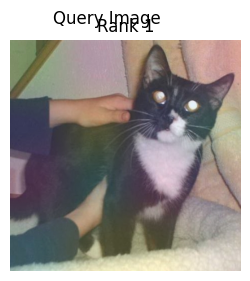

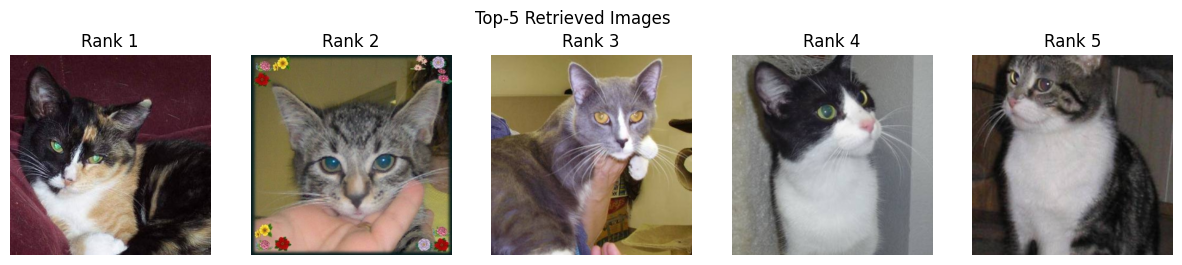

Query: cats_and_dogs/validation/cats/2001.jpg


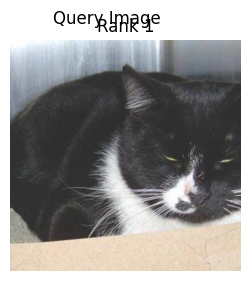

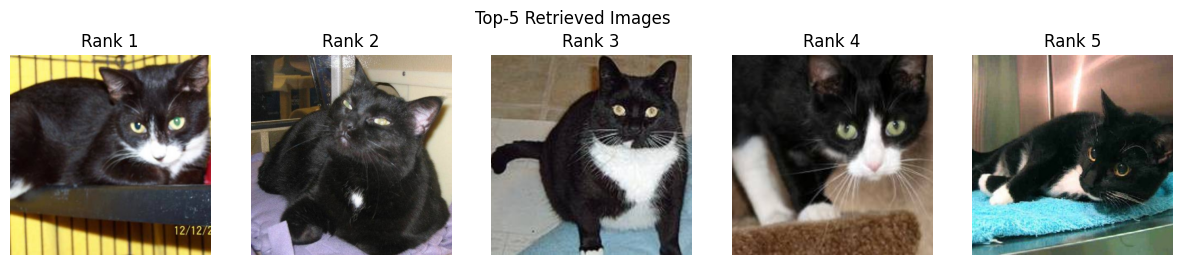

Query: cats_and_dogs/validation/cats/2002.jpg


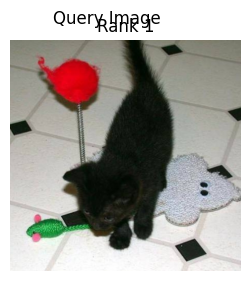

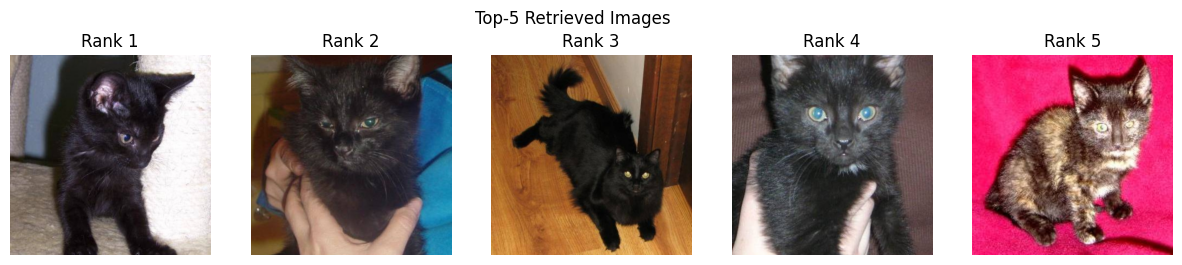

Query: cats_and_dogs/validation/dogs/2000.jpg


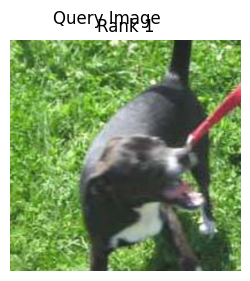

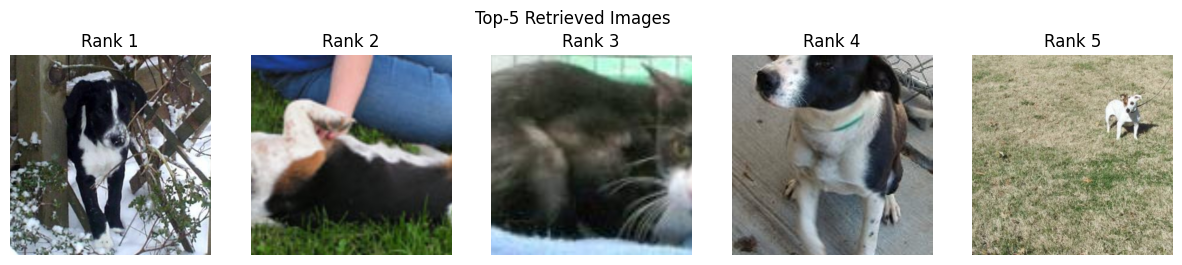

Query: cats_and_dogs/validation/dogs/2001.jpg


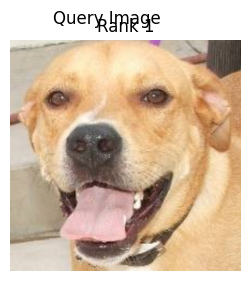

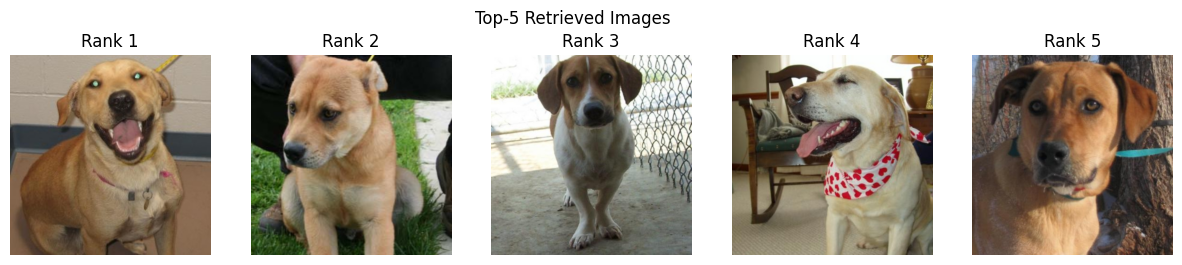

In [71]:
sample_query_paths = ["cats_and_dogs/validation/cats/2000.jpg",
                     "cats_and_dogs/validation/cats/2001.jpg",
                     "cats_and_dogs/validation/cats/2002.jpg",
                     "cats_and_dogs/validation/dogs/2000.jpg",
                     "cats_and_dogs/validation/dogs/2001.jpg"] 

id_to_path = {str(i): path for i, path in enumerate(image_paths)}

for q_path in sample_query_paths:
    img_tensor = load_and_preprocess_cnn(q_path)
    _, q_feat = extract_vgg16_features(img_tensor)
    # Query Pinecone
    result = index.query(vector=q_feat.tolist(), top_k=5, include_metadata=False)
    retrieved_ids = [match['id'] for match in result['matches']]
    retrieved_paths = [id_to_path[rid] for rid in retrieved_ids if rid in id_to_path]
    
    print(f"Query: {q_path}")
    show_images([q_path], "Query Image")
    show_images(retrieved_paths, "Top-5 Retrieved Images")

## 5 c) 

In [74]:
## Prepare ground truth

def get_label_from_path(path):
    return path.split('/')[-2]

db_labels = [get_label_from_path(p) for p in image_paths]
db_path_to_label = {p: get_label_from_path(p) for p in image_paths}

In [75]:
## Compute average precision for each query
def average_precision(retrieved_paths, query_label, db_path_to_label):
    num_relevant = 0
    precisions = []
    for i, path in enumerate(retrieved_paths, 1):
        if db_path_to_label[path] == query_label:
            num_relevant += 1
            precisions.append(num_relevant / i)
    if not precisions:
        return 0.0
    return sum(precisions) / num_relevant

aps = []
for q_path in sample_query_paths:
    img_tensor = load_and_preprocess_cnn(q_path)
    _, q_feat = extract_vgg16_features(img_tensor)
    result = index.query(vector=q_feat.tolist(), top_k=20, include_metadata=False)  # Use a larger k for PR curve
    retrieved_ids = [match['id'] for match in result['matches']]
    retrieved_paths = [id_to_path[rid] for rid in retrieved_ids if rid in id_to_path]
    query_label = get_label_from_path(q_path)
    ap = average_precision(retrieved_paths, query_label, db_path_to_label)
    aps.append(ap)
    print(f"AP for {q_path}: {ap:.3f}")

mAP = np.mean(aps)
print(f"Mean Average Precision (mAP): {mAP:.3f}")

AP for cats_and_dogs/validation/cats/2000.jpg: 1.000
AP for cats_and_dogs/validation/cats/2001.jpg: 1.000
AP for cats_and_dogs/validation/cats/2002.jpg: 1.000
AP for cats_and_dogs/validation/dogs/2000.jpg: 0.883
AP for cats_and_dogs/validation/dogs/2001.jpg: 1.000
Mean Average Precision (mAP): 0.977


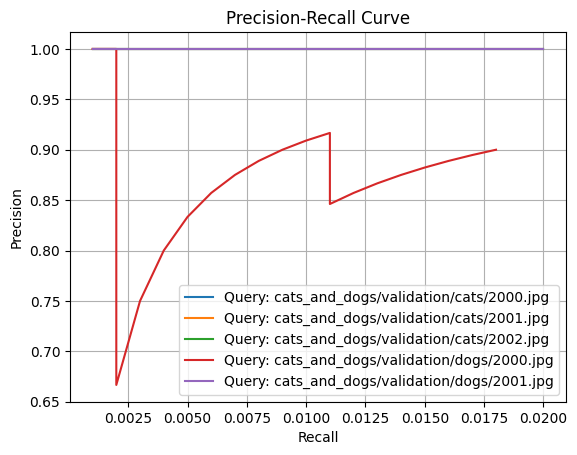

In [78]:
### Plot Precision-Recall Curve for all queries
def precision_recall_curve(retrieved_paths, query_label, db_path_to_label):
    num_relevant = sum(1 for p in db_path_to_label if db_path_to_label[p] == query_label)
    if num_relevant == 0:
        return [], []
    
    precisions = []
    recalls = []
    num_retrieved = 0
    num_correct = 0
    
    for path in retrieved_paths:
        num_retrieved += 1
        if db_path_to_label[path] == query_label:
            num_correct += 1
        precisions.append(num_correct / num_retrieved)
        recalls.append(num_correct / num_relevant)
    
    return precisions, recalls
  
for q_path in sample_query_paths:
    img_tensor = load_and_preprocess_cnn(q_path)
    _, q_feat = extract_vgg16_features(img_tensor)
    result = index.query(vector=q_feat.tolist(), top_k=20, include_metadata=False)  # Use a larger k for PR curve
    retrieved_ids = [match['id'] for match in result['matches']]
    retrieved_paths = [id_to_path[rid] for rid in retrieved_ids if rid in id_to_path]
    query_label = get_label_from_path(q_path)
    
    precisions, recalls = precision_recall_curve(retrieved_paths, query_label, db_path_to_label)
    
    plt.plot(recalls, precisions, label=f'Query: {q_path}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()


## 5 d)

In [84]:
for q_path in sample_query_paths:
    img_tensor = load_and_preprocess_cnn(q_path)
    _, q_feat = extract_vgg16_features(img_tensor)
    result = index.query(vector=q_feat.tolist(), top_k=5, include_metadata=False)
    retrieved_ids = [match['id'] for match in result['matches']]
    retrieved_paths = [id_to_path[rid] for rid in retrieved_ids if rid in id_to_path]
    query_label = get_label_from_path(q_path)
    retrieved_labels = [get_label_from_path(p) for p in retrieved_paths]
    for label in retrieved_labels:
        if label != query_label:
            # Print the query and incorrect image path
            print(f"Incorrect for query: {q_path}, retrieved: {retrieved_paths[retrieved_labels.index(label)]}")

Incorrect for query: cats_and_dogs/validation/dogs/2000.jpg, retrieved: cats_and_dogs/train/cats/595.jpg


-There could be some potential reasons for this failure including:
- Visual similarity: Some cats and dogs may look similar in color, pose, or background.
- Feature limitations: VGG16 FC features are optimized for classification, not fine-grained similarity.
- Background clutter: Non-object regions may dominate the feature vector.
- Dataset bias: Imbalanced or small datasets can cause poor generalization.

## 6 e)

-Some potential solutions to improve the retrieval results include:
- Use features from the last convolutional layer (before FC) and apply global average pooling to retain more spatial and visual information.
- We can Fine-tune our CNN on our specific dataset for better feature representation.
- We can use PCA or similar to reduce feature size, improving efficiency and possibly robustness.
- To make the most of our data and make it more robust, we can increase dataset diversity with augmentation (flips, crops, color jitter).